Found 32 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


Detected Classes: ['class_0', 'class_1', 'class_2', 'class_3']
Loading saved model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

Prediction Result
-----------------
Tumor Type: class_1
Confidence: 25.69 %


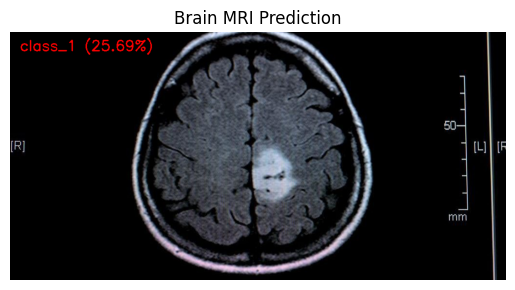

In [15]:
# ==========================================
# Brain MRI Tumor Classification - FINAL
# ==========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==========================
# SETTINGS
# ==========================

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = "brain_mri/train"
MODEL_PATH = "brain_mri_model.h5"

# ==========================
# CHECK DATASET
# ==========================

if not os.path.exists(DATA_DIR):
    raise FileNotFoundError("Dataset folder not found. Check path!")

# ==========================
# DATA GENERATOR
# ==========================

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

print("Detected Classes:", class_labels)

# ==========================
# LOAD MODEL IF EXISTS
# ==========================

if os.path.exists(MODEL_PATH):
    print("Loading saved model...")
    model = load_model(MODEL_PATH)

else:
    print("Training new model...")

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS
    )

    model.save(MODEL_PATH)
    print("Model saved successfully!")

# ==========================
# PREDICTION FUNCTION
# ==========================

def predict_image(image_path):

    if not os.path.exists(image_path):
        print("Image not found! Check file path.")
        return

    img = cv2.imread(image_path)
    original = img.copy()

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    predicted_label = class_labels[class_index]

    print("\nPrediction Result")
    print("-----------------")
    print("Tumor Type:", predicted_label)
    print("Confidence:", round(confidence * 100, 2), "%")

    # Color coding
    if predicted_label.lower() == "no_tumor":
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)

    label_text = f"{predicted_label} ({confidence*100:.2f}%)"

    cv2.putText(original, label_text, (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Display image
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title("Brain MRI Prediction")
    plt.axis("off")
    plt.show()

# ==========================
# GIVE IMAGE PATH HERE
# ==========================

predict_image("brain tumor.jpg")